## Detection 

* We have fine tune the MASK CNN Weights by running custom train on 'train_own.ipynb'
* this program amis to use this output and test the results on the ssdisplay images 

### Import Libiraries 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

In [3]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils


Using TensorFlow backend.


In [8]:

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

WEIGHTS_PATH = os.path.join(ROOT_DIR, "logs\\object20230910T1144\\mask_rcnn_object_0001.h5")


### Custom Configuration & Dataset & Training Functions

* Copy functions form Train_own
* Update IMAGES_PER_GPU = 1 

In [28]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + car and truck

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [10]:

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "ssdisplay")
        

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        if subset == 'train':
            # We mostly care about the x and y coordinates of each region
            annotations1 = json.load(open('G:\\My Drive\\02_Python_Projects\\Mask_RCNN\\train\\em_train.json'))
        else:
            annotations1 = json.load(open('G:\\My Drive\\02_Python_Projects\\Mask_RCNN\\val\\em_test.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['ssname'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"ssdisplay": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

### Load Data and Weights

In [29]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [30]:
# Load validation dataset
# Must call before using the dataset

dataset = CustomDataset()
dataset.load_custom(ROOT_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
objects: ['ssdisplay']
numids [1]
Images: 5
Classes: ['BG', 'ssdisplay']


In [31]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [32]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  G:\My Drive\02_Python_Projects\Mask_RCNN\logs\object20230910T1144\mask_rcnn_object_0001.h5
Re-starting from epoch 1


### Object Detection Part 

In [86]:
def detect_one(image1):
    # This is for predicting images which are not present in dataset
    img = mpimg.imread(image1)
    img1 = cv2.resize(img,(1024,1024))
    results1 = model.detect([img1], verbose=1)
    r1 = results1[0]
    print(r1['class_ids'])
    return results1


In [91]:
res_img1 = detect_one(ROOT_DIR + '\\images\\img1.jpg')
res_img2 = detect_one(ROOT_DIR + '\\images\\img2.jpg')
res_img3 = detect_one(ROOT_DIR + '\\images\\img3.jpg')
res_img4 = detect_one(ROOT_DIR + '\\images\\img4.jpg')
res_img5 = detect_one(ROOT_DIR + '\\images\\img5.jpg')
res_img6 = detect_one(ROOT_DIR + '\\images\\img6.jpg')
res_img7 = detect_one(ROOT_DIR + '\\images\\img7.jpg')
res_img8 = detect_one(ROOT_DIR + '\\images\\img8.jpg')
res_img9 = detect_one(ROOT_DIR + '\\images\\img9.jpg')
res_img10 = detect_one(ROOT_DIR + '\\images\\img10.jpg')

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151

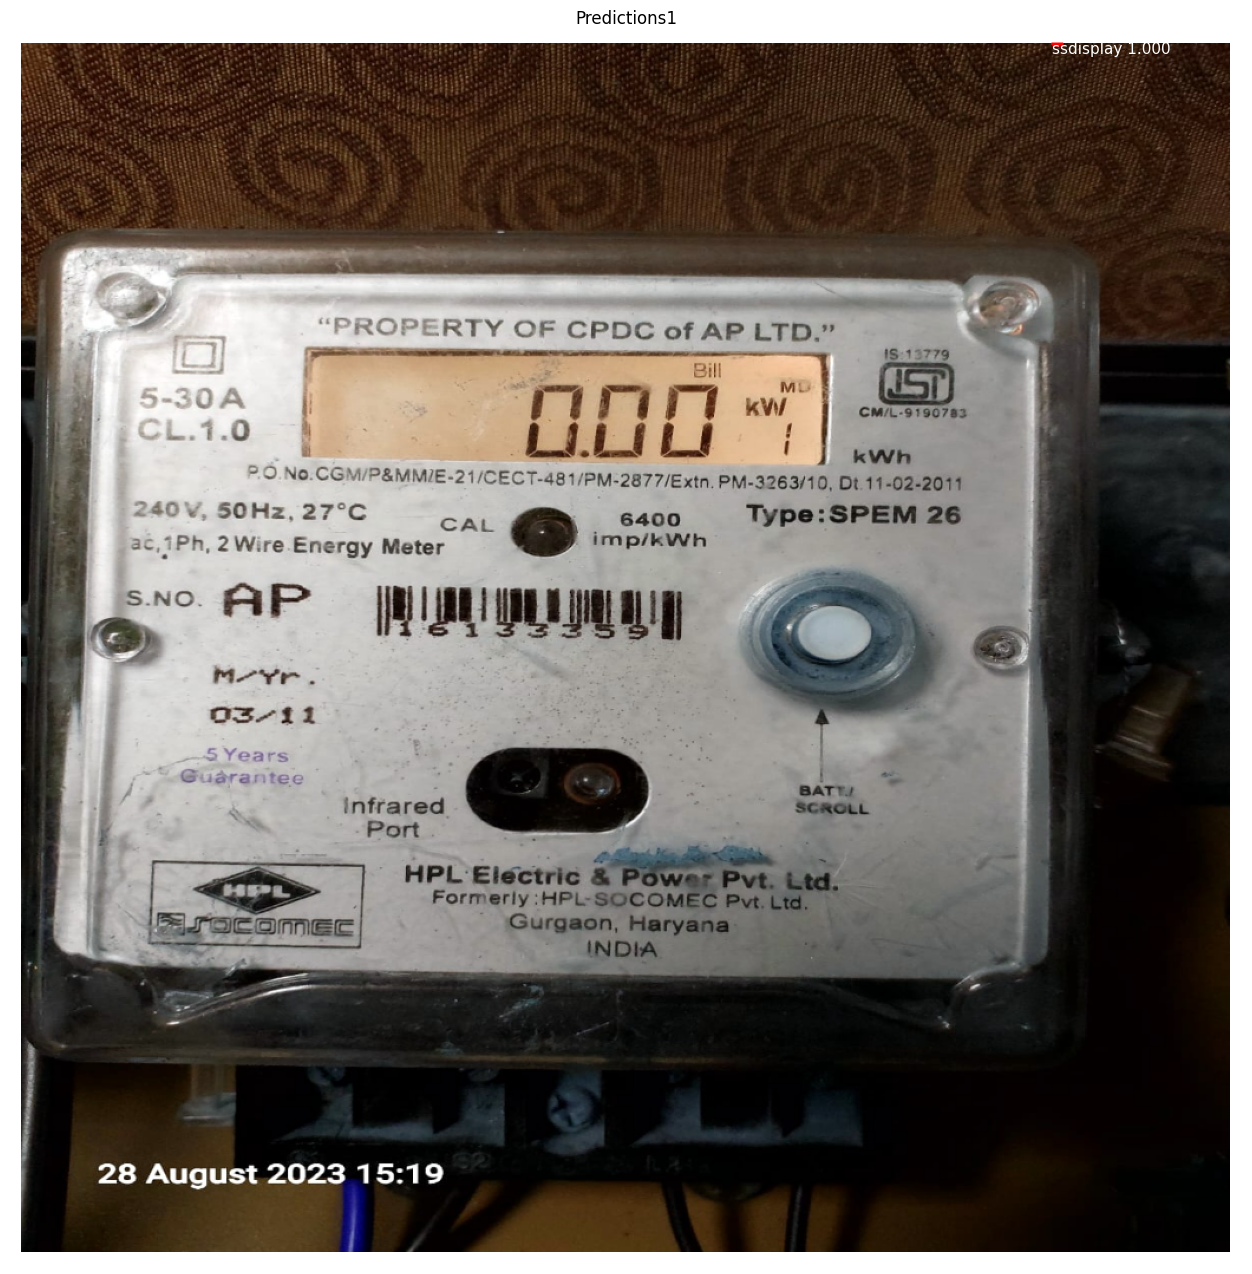

In [92]:
# Display results
ax = get_ax(1)
r1 = res_img6[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

In [93]:
r1['class_ids']

array([1])

In [94]:
r1['masks']

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

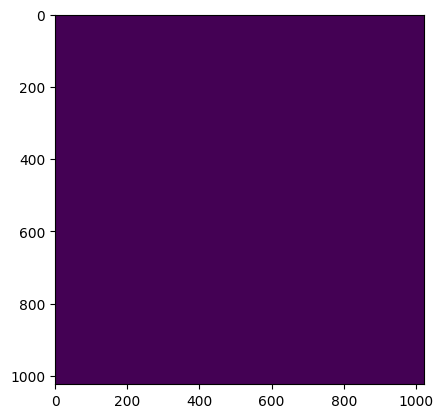

In [95]:
plt.imshow(r1['masks'])

### Detection 2 

In [97]:
class InferenceConfig(config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

TypeError: __init__() takes 1 positional argument but 4 were given